# 

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [18]:
import matplotlib.pyplot as plt

In [3]:
import time
from collections import defaultdict
from pathlib import Path

import numpy as np
import requests
import torch
from tqdm import tqdm

import fastmri
import fastmri.data.transforms as T
from fastmri.data import SliceDataset
from fastmri.models import VarNet
from fastmri.data.subsample import create_mask_for_mask_type

In [4]:
VARNET_FOLDER = "https://dl.fbaipublicfiles.com/fastMRI/trained_models/varnet/"
MODEL_FNAMES = {
    "varnet_knee_mc": "knee_leaderboard_state_dict.pt",
    "varnet_brain_mc": "brain_leaderboard_state_dict.pt",
}

{'varnet_knee_mc': 'knee_leaderboard_state_dict.pt',
 'varnet_brain_mc': 'brain_leaderboard_state_dict.pt'}

In [5]:
def download_model(url, fname):
    response = requests.get(url, timeout=10, stream=True)

    chunk_size = 8 * 1024 * 1024  # 8 MB chunks
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    progress_bar = tqdm(
        desc="Downloading state_dict",
        total=total_size_in_bytes,
        unit="iB",
        unit_scale=True,
    )

    with open(fname, "wb") as fh:
        for chunk in response.iter_content(chunk_size):
            progress_bar.update(len(chunk))
            fh.write(chunk)

In [6]:
def run_varnet_model(batch, model, device):
    crop_size = batch.crop_size

    output = model(batch.masked_kspace.to(device), batch.mask.to(device)).cpu()

    # detect FLAIR 203
    if output.shape[-1] < crop_size[1]:
        crop_size = (output.shape[-1], output.shape[-1])

    output = T.center_crop(output, crop_size)[0]

    return output, int(batch.slice_num[0]), batch.fname[0]

In [7]:
challenge = "varnet_brain_mc"
state_dict_file = None
data_path = DATA_ROOT/"multicoil_test"
output_path = RES_ROOT
device = "cpu";

'cpu'

In [10]:
model = VarNet(num_cascades=12, pools=4, chans=18, sens_pools=4, sens_chans=8);
state_dict_file = MODEL_FNAMES[challenge]
model.load_state_dict(torch.load(state_dict_file))
model = model.eval();
model = model.to(device);

In [12]:
data_transform = T.VarNetDataTransform()
dataset = SliceDataset(
        root=data_path, transform=data_transform, challenge="multicoil"
    )
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4)
dataloader1 = iter(dataloader);

In [41]:
batch = next(dataloader1);
batch.masked_kspace.abs().std()

In [43]:
res = run_varnet_model(batch, model, device);

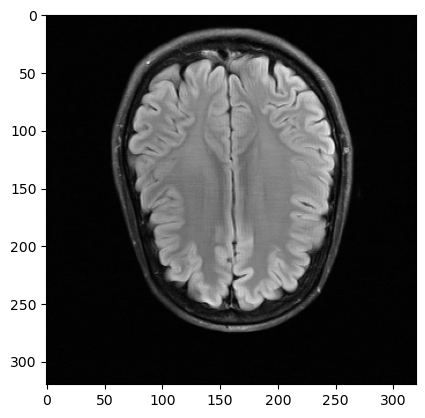

In [44]:
plt.imshow(res[0].detach().numpy(), cmap='gray')